# Homework 7: Multilayer Perceptrons

**name:** Yifeng He

**email:** yifengh@umich.edu

**I did not discussed this homework with anyone. (List *everyone* with whom you discussed any of the homework problems, excluding only the GSIs and the course instructor. If you did not discuss the homework with anyone else, write "I did not discuss this homework with anyone." Even if you discuss questions with others, you may not copy other students' solutions: the code you submit must be yours alone. All work is checked with the [MOSS plagiarism detector](https://theory.stanford.edu/~aiken/moss/).)

**This homework assignment took me 5 hours in total to complete.** (Please help us to gauge the difficulty of the assignment.)

### Submission Instructions
Your homework solutions should be written entirely in this Jupyter notebook file. Once it contains your solutions, you should submit this notebook through Canvas. Before submitting, please make sure make sure __Cells->Run__ executes without errors; errors in your code cause problems for our auto-grader. Thus, even though we frequently ask you to check for errors in your functions, you should not include in your submission any examples of your functions actually raising those errors.

### Pillow
Note that Python's Imaging Library (PIL) can be installed via

    conda install pillow
    
or

    pip install pillow


### Credits
This homework assignment is based on a homework assignment written by Sebastian Raschka (sraschka@wisc.edu)
The dataset is from him too. Please do not distribute this modified version of his work.

### Supplemental Data Files
Run the following code to download the supplemental files you will need to complete this homework:

In [1]:
from urllib import request
from os import path
from zipfile import ZipFile

url = "https://regier.stat.lsa.umich.edu/stats507/"
fn = "hw7data.zip"
if not path.exists(fn):
    data = request.urlopen(url + fn).read()
    with open(fn, 'wb') as fhand:
        fhand.write(data)
    with ZipFile(fn, 'r') as zipObj:
        zipObj.extractall()

### Coding style
Please follow the [PEP8 guidelines](https://www.python.org/dev/peps/pep-0008/). The `pycodestyle_magic` package will remind you if you are not. To install it, run
```
pip install flake8 pycodestyle_magic
```
Once it is installed the following two Jupyter directives will enable syntax checking:

In [2]:
%load_ext pycodestyle_magic
%pycodestyle_on

## Problem 1 (20 points)

Modify the Multilayer Perceptron implementation below to achieve a better performance. In particular,
- Your Validation and Test set accuracies should be >= 92%
- Answer the questions at the bottom of this notebook

Please read and execute this notebook first to make sure everything works correctly. Then, make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

In [3]:
import torch
import os
import pandas as pd
import numpy as np
import time
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# NOTE: I actually noticed that this code runs faster on the CPU than on the
# GPU, because the dataset is so small. However, you are encouraged to try
# out training on a GPU, e.g., via Google Colab.

### Loading the Dataset

The dataset consists of 3 classes:
- Drawings of "birds" (class 0)
- Drawings of "pizzas" (class 1)
- Drawings of "screwdrivers" (class 2)

(The dataset is based on Google Quickdraw: I wrote a script to fetch the images from the database here: https://quickdraw.withgoogle.com/data)

The dataset is very small on purpose so that the training should be relatively fast (but this wouldn't be an ideal DL dataset because of its small size).

In [5]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))

Class distribution Train [8005 7669 6826]


The images are 28x28 dimensional (grayscale).

Some examples:

png-files\bird_000043.png


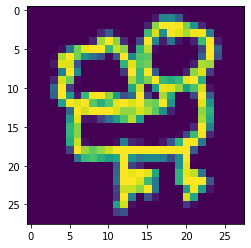

png-files\bird_000107.png


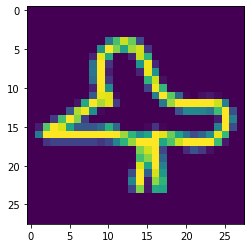

png-files\pizza_000000.png


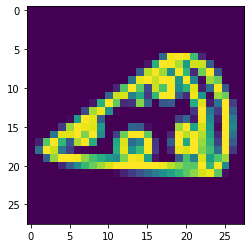

png-files\pizza_000002.png


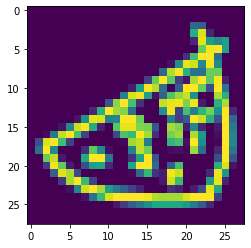

png-files\screwdriver_000001.png


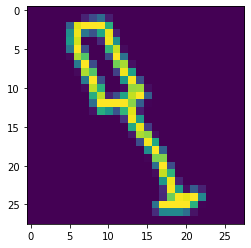

png-files\screwdriver_000012.png


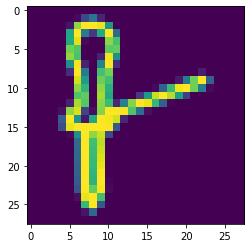

In [6]:
import glob
image_paths = sorted(glob.glob('png-files/*.png'))
for i in (12, 25, 30000, 30001, 60000, 60005):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

---

- The only thing you should change in this section during experimenting is the batch size
- However, it is not required to make changes to the batch size

In [7]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [8]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
custom_transform = transforms.Compose([transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='png-files/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,  # CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=0)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='png-files/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='png-files/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=0)

The cell below just checks if the dataset can be loaded correctly.

In [9]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 128
break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

### Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [10]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()

        self.num_classes = num_classes

        # ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)

    def forward(self, x):
        # MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        # ANYTHNG IN THE __init__ METHOD ABOVE
        out = self.linear_1(x)
        out = torch.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas


# Model Initialization


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
torch.manual_seed(RANDOM_SEED)

# IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU
# ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
# added a second hidden layer, you may want to add a
# hidden_2 parameter here. Also you may want to play
# with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=60,
            num_hidden_2=60,
            num_classes=3)

model = model.to(DEVICE)


# For this homework, do not change the optimizer. However, you
# likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

In [14]:
# Training


# PLEASE DON'T CHANGE THE compute_epoch_loss
# and the compute accuracy functions

def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


start_time = time.time()
minibatch_cost = []
epoch_cost = []

# NO NEED TO CHANGE ANYTHING BELOW. HOWEVER, YOU CAN CHANGE
# THE NUMBER OF EPOCHS IF YOU LIKE

# remember to change here
NUM_EPOCHS = 8

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)

        # FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        minibatch_cost.append(cost)

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                  % (epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))

    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)

    train_accuracy = compute_accuracy(model, train_loader)
    valid_accuracy = compute_accuracy(model, valid_loader)

    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Train Accuracy: %.3f | Validation Accuracy: %.3f'
          % (train_accuracy, valid_accuracy))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/008 | Batch 000/176 | Cost: 1.1013
Epoch: 001/008 | Batch 050/176 | Cost: 0.4427
Epoch: 001/008 | Batch 100/176 | Cost: 0.3710
Epoch: 001/008 | Batch 150/176 | Cost: 0.3255
Epoch: 001/008 Train Cost: 0.3408
Train Accuracy: 88.316 | Validation Accuracy: 88.200
Time elapsed: 0.61 min
Epoch: 002/008 | Batch 000/176 | Cost: 0.3052
Epoch: 002/008 | Batch 050/176 | Cost: 0.3498
Epoch: 002/008 | Batch 100/176 | Cost: 0.2790
Epoch: 002/008 | Batch 150/176 | Cost: 0.2856
Epoch: 002/008 Train Cost: 0.2871
Train Accuracy: 90.329 | Validation Accuracy: 89.640
Time elapsed: 1.26 min
Epoch: 003/008 | Batch 000/176 | Cost: 0.2659
Epoch: 003/008 | Batch 050/176 | Cost: 0.3181
Epoch: 003/008 | Batch 100/176 | Cost: 0.1769
Epoch: 003/008 | Batch 150/176 | Cost: 0.3471
Epoch: 003/008 Train Cost: 0.2575
Train Accuracy: 91.298 | Validation Accuracy: 90.240
Time elapsed: 1.95 min
Epoch: 004/008 | Batch 000/176 | Cost: 0.2432
Epoch: 004/008 | Batch 050/176 | Cost: 0.1649
Epoch: 004/008 | Batch 100

### Evaluation (No Need To Change Any Code in This Section!)

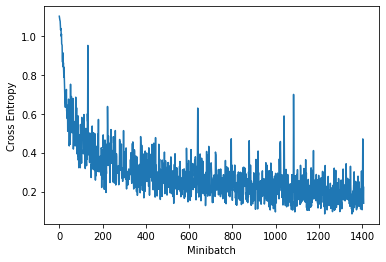

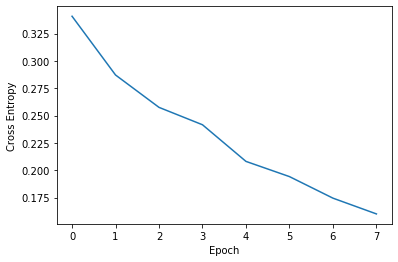

In [15]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [16]:
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Test Accuracy: 92.18


### Conclusions (YOUR ANSWERS REQUIRED)

**1) What is your training, validation, and test accuracy (paste your numbers from above)? Also, do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?**

From the above, the training dataset accuracy: 94.867%, the rest dataset accuracy: 92.280, the test accuracy: 92.18%.

My model doesn't have overfitting, since the test accuracy, the training accuracy, and the validation accuracy are all close to each other as shown above.

**2) What architectual changes did you make to improve the performance?**

1. Changed the learning rate from 0.05 to 0.2.
2. Added one more hidden layer. 
3. Changed the activation function from sigmoid to ReLU and leaky_ReLU
4. Changed the number of epochs from 25 to 8 in order to avoid overfitting
5. changed the number of in the hidden layers from 50 to 60

**3) Assuming you increased the accuracy by 3%, how many more correct predictions did the improved model make in the test set?**

[Provide a short calculation and number (i.e., provide a count of images)]<br>
From the result below, we could see that there are 65,000 images in the test dataset. Thus, if I imporve the accuracy by 3%, I could make 1950(65000*3%) more correct predictions.    

In [21]:
len(test_dataset)

65000